# Population per country

Select a continent **or** describe the countries to filter.

Data source: [ourworldindata.org](https://ourworldindata.org/population-growth)

In [1]:
%matplotlib widget

In [2]:
import json
from dataclasses import dataclass

import ipywidgets as widgets
import matplotlib.animation as animation
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
from IPython.display import display
from openai import OpenAI

/var/folders/p_/tdg15_tn0rq_b63np2rwrrpc0000gn/T/ipykernel_68724/4122518466.py:9: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
# some countries don't match between datasets (matches generated by ChatGPT :D)
mapping = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Bonaire, Sint Eustatius and Saba": "Bonaire Sint Eustatius and Saba",
    "British Indian Ocean Territory": "British Virgin Islands",
    "Brunei Darussalam": "Brunei",
    "Cabo Verde": "Cape Verde",
    "Curaçao": "Curacao",
    "Côte d'Ivoire": "Cote d'Ivoire",
    "Congo, Democratic Republic of the": "Democratic Republic of Congo",
    "Iran (Islamic Republic of)": "Iran",
    "Korea (Democratic People's Republic of)": "North Korea",
    "Korea, Republic of": "South Korea",
    "Lao People's Democratic Republic": "Laos",
    "Micronesia (Federated States of)": "Micronesia (country)",
    "Moldova, Republic of": "Moldova",
    "Palestine, State of": "Palestine",
    "Russian Federation": "Russia",
    "Réunion": "Reunion",
    "Saint Barthélemy": "Saint Barthelemy",
    "Saint Helena, Ascension and Tristan da Cunha": "Saint Helena",
    "Syrian Arab Republic": "Syria",
    "Taiwan, Province of China": "Taiwan",
    "Tanzania, United Republic of": "Tanzania",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "Viet Nam": "Vietnam",
    "Virgin Islands (British)": "British Virgin Islands",
    "Virgin Islands (U.S.)": "United States Virgin Islands",
}

In [4]:
# load population dataset, match names and add region column
countries = pd.read_csv(
    "https://raw.githubusercontent.com/lukes/ISO-3166-Countries-with-Regional-Codes/master/all/all.csv"
)
countries["name"] = countries["name"].replace(mapping)
countries = countries[["name", "region"]]

df = pd.read_csv("population-and-demography.csv")
df = df.merge(countries, left_on="Country name", right_on="name")

# country names
country_names = df["Country name"].unique().tolist()

# continents
regions = countries["region"]
regions = sorted(regions[~regions.isna()].unique())

In [5]:
client = OpenAI()

sys_prompt = f"""
You're a system that filters countries from a list.
Your job is to produce a new list of countries based on a user query.
You should produce JSON output with a list of countries, no keys

The list is the following:

{country_names}
"""


def get_countries_from_message(message):
    """Return a list of countries given a description"""
    response = client.chat.completions.create(
        model="gpt-3.5-turbo-0125",
        messages=[
            {"role": "system", "content": sys_prompt},
            {"role": "user", "content": message},
        ],
    )

    return json.loads(response.choices[0].message.content)


def get_year_intervals(df, window_size):
    """
    Returns the year intervals for each frame in the animation,
    controling how many years of data are plotted at any given time
    """
    min_, max_ = df["Year"].min(), df["Year"].max()
    range_ = max_ - min_ + 1

    years = []

    for i in range(range_):
        if i < window_size:
            years.append((min_, min_ + i))
        else:
            years.append((min_ + i - window_size + 1, min_ + i))

    years.append((min_, max_))
    
    return years


def sort_by_latest_year_population(df):
    """Sort data frame by population in the most recent year and return country names"""
    latest_year = df["Year"].max()
    df_latest_year = df[df["Year"] == latest_year]
    return df_latest_year.sort_values("Population", ascending=False)[
        "Country name"
    ].tolist()


@dataclass
class State:
    """Holds variables that control the plot"""

    # number of countries to plot (when selecting continent), most populated first
    n_countries_to_plot: int = 10
    # records if the animation is running or not
    running: bool = True
    # duration in ms for each frame
    frame_interval: int = 100
    # selected region by default in the dropdown
    default_region: str = "Americas"
    # the data frame with the data to plot (value set in __post_init__)
    df_subset = None

    # number of years to plot
    _window_size: int = 10
    # year bounds for each frame, computed using _window_size
    _years_intervals: list = None

    def __post_init__(self):
        self._years_intervals = get_year_intervals(df, window_size=self.window_size)
        self.df_subset = df[df["region"] == self.default_region]

    @property
    def window_size(self):
        return self._window_size

    @window_size.setter
    def window_size(self, value):
        self._window_size = value
        self._years_intervals = get_year_intervals(df, window_size=value)

    @property
    def years_intervals(self):
        return self._years_intervals


state = State()

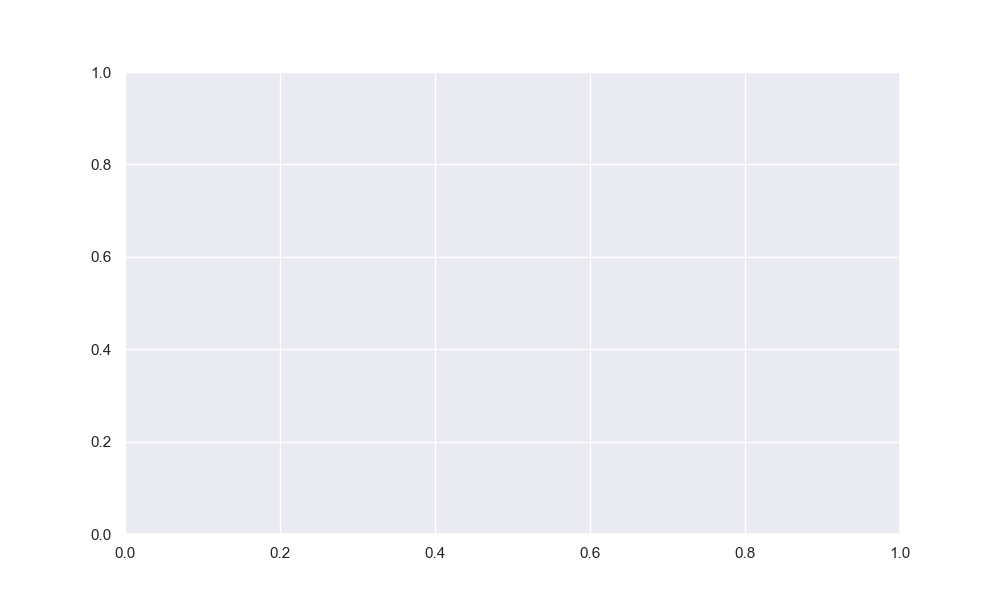

In [6]:
sns.set_theme()
fig, ax = plt.subplots(figsize=(10, 6))


def format_func(value, tick_number):
    # convert to billions (B) if value is >= 1e9
    if value >= 1e9:
        billion_value = value / 1e9
        if billion_value == int(billion_value):
            return "{:.0f}B".format(billion_value)
        else:
            return "{:.1f}B".format(billion_value)
    # convert to millions (M) if value is >= 1e6
    elif value >= 1e6:
        million_value = value / 1e6
        if million_value == int(million_value):
            return "{:.0f}M".format(million_value)
        else:
            return "{:.1f}M".format(million_value)
    else:
        return value


def update(frame):
    """Compute the frame to show"""
    last_frame = len(state.years_intervals) - 1 == frame
    ax.clear()

    year_min, year_max = state.years_intervals[frame]
    df_to_plot = state.df_subset[
        (state.df_subset["Year"] >= year_min) & (state.df_subset["Year"] <= year_max)
    ]

    countries_ordered_by_population = sort_by_latest_year_population(df_to_plot)[
        : state.n_countries_to_plot
    ]

    df_to_plot = df_to_plot[
        df_to_plot["Country name"].isin(countries_ordered_by_population)
    ]

    sns.lineplot(
        data=df_to_plot,
        x="Year",
        y="Population",
        hue="Country name",
        hue_order=countries_ordered_by_population,
        style="Country name" if not last_frame else None,
        dashes=False,
        ax=ax,
        markers=True,
    )

    # Set the legend outside the plot
    ax.legend(bbox_to_anchor=(1.05, 1), loc="upper left")

    # Adjust the layout to leave space for the legend
    plt.subplots_adjust(right=0.75)

    ax.yaxis.set_major_formatter(ticker.FuncFormatter(format_func))
    ax.xaxis.set_major_formatter(
        ticker.FuncFormatter(lambda x, pos: "{:0.0f}".format(x))
    )

    return ax


def on_play_pause_button_clicked(b):
    if not ani.event_source:
        return

    if state.running:
        ani.pause()
        state.running = False
    else:
        ani.resume()
        state.running = True


def on_reset_button_clicked(b):
    if ani.event_source is None:
        ani.__init__(
            fig=fig,
            func=update,
            frames=len(state.years_intervals),
            interval=state.frame_interval,
            repeat=False,
        )
        ani._init_draw()
    else:
        ani.event_source.stop()
        ani.frame_seq = ani.new_frame_seq()
        ani.event_source.start()


def on_dropdown_change(change):
    state.df_subset = df[df["region"] == change["new"]]
    on_reset_button_clicked(b=None)


def on_text_submit(change):
    selected = get_countries_from_message(change["new"])
    state.df_subset = df[df["Country name"].isin(selected)]
    on_reset_button_clicked(b=None)


play_pause = widgets.Button(description="Play/Pause")
play_pause.on_click(on_play_pause_button_clicked)

reset = widgets.Button(description="Reset")
reset.on_click(on_reset_button_clicked)

dropdown = widgets.Dropdown(
    options=regions,
    value=state.default_region,
    description="Continent:",
)
dropdown.observe(on_dropdown_change, names="value")

text = widgets.Text(
    value="",
    placeholder="Countries with the best cuisine",
    description="Describe:",
)
text.continuous_update = False
text.observe(on_text_submit, "value")

# layout
top = widgets.HBox([dropdown, text], layout=widgets.Layout(justify_content="center"))
bottom = widgets.HBox(
    [play_pause, reset], layout=widgets.Layout(justify_content="center")
)
display(widgets.VBox([top, bottom]))

# create animation
ani = animation.FuncAnimation(
    fig=fig,
    func=update,
    frames=len(state.years_intervals),
    interval=state.frame_interval,
    repeat=False,
)

> **Note:** GPT-3.5 (OpenAI) processes the content from the text field, so use it responsibly!